# Data download

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

* Download model to check the language from fasttext

In [2]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.1-py3-none-any.whl (238 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4246763 sha256=40cef475d1c26e0e2a3b036306958290fd48642353233cb82a5b90181bbfc325
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [3]:
# https://fasttext.cc/docs/en/language-identification.html
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz

--2024-06-30 19:38:52--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.78, 13.226.210.15, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 938013 (916K) [binary/octet-stream]
Saving to: ‘lid.176.ftz’

lid.176.ftz         100%[===================>] 916.03K  --.-KB/s    in 0.1s    

2024-06-30 19:38:52 (8.87 MB/s) - ‘lid.176.ftz’ saved [938013/938013]



In [4]:
import fasttext
model = fasttext.load_model('/content/lid.176.ftz')
print(model.predict('निचले पटल के लिए डिफोल्ट प्लग-इन खाका', k=1))  # top 2 matching languages

(('__label__hi',), array([0.95343572]))


## Load dataset

In [5]:
df = pd.read_csv('/content/hindi_english_parallel.csv', nrows=50000)
df.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,Give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,Accerciser Accessibility Explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,A list of plugins that are disabled by default


In [6]:
df.isnull().sum()

hindi       3
english    13
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.shape

(49984, 2)

In [9]:
df.sample(4)

,hindi,english
32930,डेटा परियोजना (_ a),D _ ata project
14784,कृपया लक्ष्य नाम,Please specify target name
4333,खेल सांख्यिकी दिखायें,Show gameplay statistics
47149,फंक्शन,Function


In [10]:
import string
from string import digits

## Cleaning dataset

In [11]:
# Lowercase all characters
df['english']=df['english'].apply(lambda x: x.lower())
# Remove quotes
df['english']=df['english'].apply(lambda x: re.sub("'", '', x))
df['hindi']=df['hindi'].apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
df['english']=df['english'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df['hindi']=df['hindi'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
df['english']=df['english'].apply(lambda x: x.translate(remove_digits))
df['hindi']=df['hindi'].apply(lambda x: x.translate(remove_digits))

df['hindi'] = df['hindi'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))
# if english text in hindi column
df['hindi'] = df['hindi'].apply(lambda x: re.sub("[A-Za-z]", "", x))

# remove extra
df['english']=df['english'].apply(lambda x: re.sub('[-_.:;\[\]\|,]', '', x))
df['hindi']=df['hindi'].apply(lambda x: re.sub('[-_.;\[\]\|,]', '', x))

# Remove extra spaces
df['english']=df['english'].apply(lambda x: x.strip())
df['hindi']=df['hindi'].apply(lambda x: x.strip())
df['english']=df['english'].apply(lambda x: re.sub(" +", " ", x))
df['hindi']=df['hindi'].apply(lambda x: re.sub(" +", " ", x))

In [12]:
df.sample(5)

,hindi,english
24204,सभी फ़ाइल सहेजें,save all files
40556,न्यूनतम ऊंचाई,min height
682,यूआरआई,uri
42303,हाशिया दायाँ,margin right
21319,बैकअप फ़ाइल नहीं दिखाएँ,do not show backup files


In [13]:
df['is_hindi'] = True
df['is_english'] = True

## Check language of text

In [14]:
error = []
count = 0
for i,row in tqdm(df.iterrows()):

  if i == 0:
    continue  # Skip the first row to avoid out-of-bounds error

    hi_tex = df.iloc[i-1]['hindi']
    en_tex = df.iloc[i-1]['english']
    try:
        hin_pred = model.predict(hi_tex,k=3)[0]
        if set(['__label__hi']).issubset(hin_pred) or set(['__label__mr']).issubset(hin_pred):
            pass
        else:
            df.at[i,'is_hindi'] = False
            count += 1
        en_pred = model.predict(en_tex,k=3)[0]
        if set(['__label__en']).issubset(en_pred):
            pass
        else:
            df.at[i,'is_english'] = False
            count += 1
    except:
        error.append(i)

49984it [00:03, 16440.31it/s]


In [15]:
df[df.is_english == False].shape

(0, 4)

In [16]:
df[df.is_hindi == False].shape

(0, 4)

In [17]:
df.shape

(49984, 4)

In [18]:
df = df[~df.is_hindi == False]
df = df[~df.is_english == False]
df.shape

(49984, 4)

In [19]:
df.drop(columns=['is_hindi','is_english'],inplace=True)

## Len of sentence

In [20]:
df['hindi_len'] = df['hindi'].apply(lambda x: len(x.split()))
df['english_len'] = df['english'].apply(lambda x: len(x.split()))

<Axes: xlabel='hindi_len', ylabel='Count'>

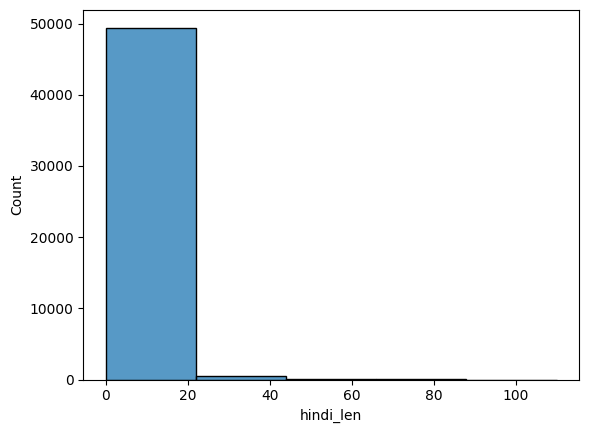

In [21]:
sns.histplot(df.hindi_len, bins=5)

<Axes: xlabel='english_len', ylabel='Count'>

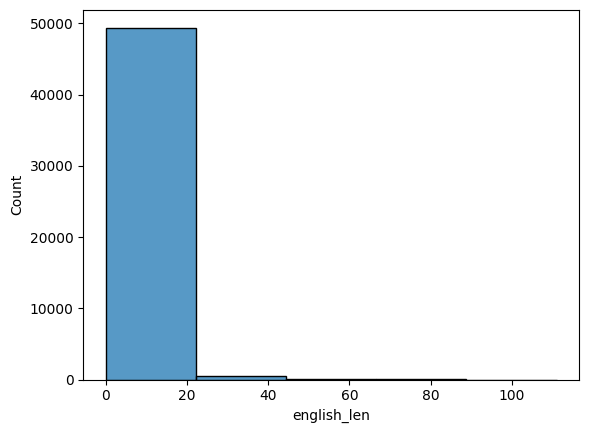

In [22]:
sns.histplot(df.english_len, bins=5)

In [23]:
# english
for i in np.arange(0.1,1.1,0.1):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(df.english_len, i)))

10 Quantile is 1.0
20 Quantile is 1.0
30 Quantile is 2.0
40 Quantile is 2.0
50 Quantile is 3.0
60 Quantile is 3.0
70 Quantile is 5.0
80 Quantile is 6.0
90 Quantile is 9.0
100 Quantile is 111.0


In [24]:
# english
for i in np.arange(0.9,1.01,0.01):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(df.english_len, i)))

90 Quantile is 9.0
91 Quantile is 9.0
92 Quantile is 10.0
93 Quantile is 10.0
94 Quantile is 11.0
95 Quantile is 11.0
96 Quantile is 12.0
97 Quantile is 14.0
98 Quantile is 17.0
99 Quantile is 24.0
100 Quantile is 111.0


In [25]:
# hindi
for i in np.arange(0.1,1.1,0.1):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(df.hindi_len, i)))

10 Quantile is 1.0
20 Quantile is 1.0
30 Quantile is 2.0
40 Quantile is 2.0
50 Quantile is 3.0
60 Quantile is 3.0
70 Quantile is 4.0
80 Quantile is 6.0
90 Quantile is 8.0
100 Quantile is 110.0


In [26]:
# hindi
for i in np.arange(0.9,1.01,0.01):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(df.hindi_len, i)))

90 Quantile is 8.0
91 Quantile is 9.0
92 Quantile is 9.0
93 Quantile is 10.0
94 Quantile is 10.0
95 Quantile is 11.0
96 Quantile is 12.0
97 Quantile is 14.0
98 Quantile is 16.0
99 Quantile is 23.0
100 Quantile is 110.0


* For both we only those data who has less than or euqal to 10

In [27]:
df = df[df.english_len<=10]
df = df[df.hindi_len<=10]
df.shape

(46103, 4)

In [28]:
df['hi_inp'] = '<start> ' + df.hindi
df['hi_out'] = df.hindi + ' <end>'

In [29]:
df.drop(columns=['english_len','hindi_len', 'hindi'],inplace=True)

In [30]:
# split dataset
from sklearn.model_selection import train_test_split
train, validation = train_test_split(df, test_size=0.2, random_state=42)

In [31]:
# checking shape
print(train.shape, validation.shape)

# add <end> in first row so we can use same tokenizer for both hi_inp and eng_out
train.hi_inp.iloc[0]= str(train.hi_inp.iloc[0]) + ' <end>'

(36882, 3) (9221, 3)


## Data preprocessing

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [33]:
# Tokenization on data
token_eng = Tokenizer()
token_eng.fit_on_texts(train['english'].values)
token_hi = Tokenizer(filters='')
token_hi.fit_on_texts(train['hi_inp'].values)

In [34]:
vocab_size_eng=len(token_eng.word_index.keys())
print('Vocab size of english is',vocab_size_eng)
vocab_size_hi=len(token_hi.word_index.keys())
print('Vocab size of hindi is',vocab_size_hi)

Vocab size of english is 3106
Vocab size of hindi is 3317


In [35]:
token_hi.word_index['<start>'], token_hi.word_index['<end>']

(1, 2979)

In [36]:
# convert text to numbers
train_dec_in = token_hi.texts_to_sequences(train.hi_inp)
train_hi_inp = token_eng.texts_to_sequences(train.english)

In [37]:
max_len = 10
# test to sequence
train_dec_in = token_hi.texts_to_sequences(train.hi_inp)
train_dec_out = token_hi.texts_to_sequences(train.hi_out)
train_eng_inp = token_eng.texts_to_sequences(train.english)

# padding
train_dec_in_seq = pad_sequences(train_dec_in, maxlen=max_len, padding='post', dtype='int32')
train_dec_out_seq = pad_sequences(train_dec_out, maxlen=max_len, padding='post', dtype='int32')
train_eng_inp_seq = pad_sequences(train_eng_inp, maxlen=max_len, padding='post', dtype='int32')

# test to sequence
test_dec_in = token_hi.texts_to_sequences(validation.hi_inp)
test_dec_out = token_hi.texts_to_sequences(validation.hi_out)
test_eng_inp = token_eng.texts_to_sequences(validation.english)

# padding
test_dec_in_seq = pad_sequences(test_dec_in, maxlen=max_len, padding='post', dtype='int32')
test_dec_out_seq = pad_sequences(test_dec_out, maxlen=max_len, padding='post', dtype='int32')
test_eng_inp_seq = pad_sequences(test_eng_inp, maxlen=max_len, padding='post', dtype='int32')

In [38]:
enc_input_length, dec_input_length, dec_out_length = 10,10,10

In [39]:
index = 0
print('Encoder text :',train.english.iloc[index])
print('Representation :',train_eng_inp_seq[index])

print('hi text :', train.hi_inp.iloc[index])
print('Decoder input :',train_dec_in_seq[index])

print('Decoder output :',train.hi_out.iloc[index])
print('Decoder output :',train_dec_out_seq[index])

Encoder text : alpha object to drive the behaviour
Representation : [ 331  141    2  224    1 1913    0    0    0    0]
hi text : <start> व्यवहार ड्राइव करने के लिए अल्फा ऑब्जेक्ट <end>
Decoder input : [   1 1572  226   52    3   11  292  763 2979    0]
Decoder output : व्यवहार ड्राइव करने के लिए अल्फा ऑब्जेक्ट <end>
Decoder output : [1572  226   52    3   11  292  763 2979    0    0]


In [40]:
# create a dictionaries from num to word and vice versa
hi_index_word = {}
hi_word_index = {}

for key, value in token_hi.word_index.items():
    hi_index_word[value] = key
    hi_word_index[key] = value

In [41]:
hi_vocab_size = len(token_hi.word_index)+1
eng_vocab_size = len(token_eng.word_index)+1

print('hindi vocab size',hi_vocab_size)
print('english vocab size',eng_vocab_size)

hindi vocab size 3318
english vocab size 3107


## Data Generator

In [42]:
# reference : https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/

def data_generator(encoder_inp, decoder_inp, decoder_out, batch_size):
    '''
    Data Generator for model training
    It returns list of encoder_imput and decoder_input of each shape [batch_size, max_len]
    and decoder_out of shape (batch_size, max_len)
    '''
    while True:
        for i in range(0, len(encoder_inp), batch_size):
            # creating empty matrix
            enc_inp_batch = np.zeros(shape = (batch_size, encoder_inp.shape[-1])) # shape = (batch_size, max_len)
            dec_inp_batch = np.zeros(shape = (batch_size, decoder_inp.shape[-1])) # shape = (batch_size, max_len)
            dec_out_batch = np.zeros(shape = (batch_size, decoder_out.shape[-1])) # shape = (batch_size, max_len)
            for j in range(batch_size):
                if (i+j) < len(encoder_inp):
                    # adding batch wise values
                    enc_inp_batch[j] = encoder_inp[i+j]
                    dec_inp_batch[j] = decoder_inp[i+j]
                    dec_out_batch[j] = decoder_out[i+j]
            # Yield is a keyword in Python that is used to return from a function without
            # destroying the states of its local variable and when the function is called,
            # the execution starts from the last yield statement.
            yield [enc_inp_batch, dec_inp_batch], dec_out_batch

# Model

In [43]:
from tensorflow.keras.layers import Embedding, LSTM, Input, Dense, RNN, LSTMCell, Activation, add, concatenate
from tensorflow.keras.models import Model

## Encoder - Decoder Seq-Seq model

In [44]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        super().__init__()
        #Initialize Embedding layer
        self.embedding = Embedding(inp_vocab_size, embedding_size, input_length = input_length)
        #Intialize Encoder LSTM layer
        self.lstm_size = lstm_size
        lstmcell = LSTMCell(lstm_size)
        self.lstm = RNN(lstmcell, return_sequences = True, return_state = True)


    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          returns -- encoder_output, last time step's hidden and cell state
        '''
        embeddings = self.embedding(input_sequence)

        encoder_output, encoder_final_state_h, encoder_final_state_c = self.lstm(embeddings, initial_state = states)

        return encoder_output, encoder_final_state_h, encoder_final_state_c


    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      '''
      return tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))

In [45]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.lstm_size = lstm_size
        #Initialize Embedding layer
        self.embed_layer = Embedding(input_dim=out_vocab_size, output_dim=embedding_size, input_length=input_length)
        #Intialize Decoder LSTM layer
        lstmcell = LSTMCell(lstm_size)
        self.lstm_layer = RNN(lstmcell, return_sequences=True, return_state=True)


    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm

          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        x = self.embed_layer(input_sequence)
        decoder_output,decoder_final_state_h,decoder_final_state_c = self.lstm_layer(x, initial_state = initial_states)
        return decoder_output,decoder_final_state_h,decoder_final_state_c

In [46]:
class Encoder_decoder(tf.keras.Model):

    def __init__(self, ita_vocab_size, eng_vocab_size, enc_embedding_size, dec_embedding_size, lstm_size,
                 enc_input_length, dec_input_length):
        super().__init__()
        #Create encoder object
        self.encode_obj = Encoder(ita_vocab_size,enc_embedding_size,lstm_size,enc_input_length)
        #Create decoder object
        self.decode_obj = Decoder(eng_vocab_size,dec_embedding_size,lstm_size,dec_input_length)
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = Dense(eng_vocab_size, activation='softmax')
        self.enc_input_length = enc_input_length

    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer

        Return decoder_outputs
        '''
        enc_data = data[0]
        dec_data = data[1]

        # A
        enc_initial_state = self.encode_obj.initialize_states(tf.shape(enc_data)[0])
        enc_out, enc_h, enc_c = self.encode_obj(enc_data,enc_initial_state)

        # B
        dec_out, dec_h, dec_c = self.decode_obj(dec_data, [enc_h, enc_c])
        # C
        x = self.dense(dec_out)
        return x

In [47]:
enc_embedding_size = 50
dec_embedding_size = 100
lstm_size = 128

# defining model
en_hi_model = Encoder_decoder(eng_vocab_size, hi_vocab_size, enc_embedding_size, dec_embedding_size, lstm_size,
                 enc_input_length, dec_input_length)

In [48]:
# model compile
en_hi_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy')

from tensorflow.keras.callbacks import EarlyStopping
# setting tensorboard
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

# directory to save log
log_dir='/content/logs/fit/en_hi_model/'

# call back of tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
callback = [tensorboard_callback, early_stop]

In [49]:
batch_size = 444
# send data to data generators
train_data_generator = data_generator(train_eng_inp_seq, train_dec_in_seq, train_dec_out_seq, batch_size)
val_data_generator = data_generator(test_eng_inp_seq, test_dec_in_seq, test_dec_out_seq, batch_size)

# train model
en_hi_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

Epoch 1/10
83/83 [==============================] - 36s 307ms/step - loss: 3.9568 - val_loss: 2.4973
Epoch 2/10
83/83 [==============================] - 4s 48ms/step - loss: 2.3717 - val_loss: 2.1965
Epoch 3/10
83/83 [==============================] - 5s 66ms/step - loss: 2.1290 - val_loss: 2.0515
Epoch 4/10
83/83 [==============================] - 4s 46ms/step - loss: 2.0107 - val_loss: 1.9613
Epoch 5/10
83/83 [==============================] - 4s 49ms/step - loss: 1.9291 - val_loss: 1.8914
Epoch 6/10
83/83 [==============================] - 5s 58ms/step - loss: 1.8661 - val_loss: 1.8373
Epoch 7/10
83/83 [==============================] - 4s 52ms/step - loss: 1.8116 - val_loss: 1.7876
Epoch 8/10
83/83 [==============================] - 4s 53ms/step - loss: 1.7591 - val_loss: 1.7397
Epoch 9/10
83/83 [==============================] - 6s 73ms/step - loss: 1.7072 - val_loss: 1.6902
Epoch 10/10
83/83 [==============================] - 4s 47ms/step - loss: 1.6518 - val_loss: 1.6391


In [50]:
en_hi_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

Epoch 1/10
83/83 [==============================] - 5s 64ms/step - loss: 1.5991 - val_loss: 1.5903
Epoch 2/10
83/83 [==============================] - 4s 46ms/step - loss: 1.5453 - val_loss: 1.5425
Epoch 3/10
83/83 [==============================] - 4s 52ms/step - loss: 1.4959 - val_loss: 1.4950
Epoch 4/10
83/83 [==============================] - 5s 61ms/step - loss: 1.4451 - val_loss: 1.4484
Epoch 5/10
83/83 [==============================] - 4s 46ms/step - loss: 1.3953 - val_loss: 1.4026
Epoch 6/10
83/83 [==============================] - 5s 60ms/step - loss: 1.3464 - val_loss: 1.3573
Epoch 7/10
83/83 [==============================] - 5s 56ms/step - loss: 1.3001 - val_loss: 1.3140
Epoch 8/10
83/83 [==============================] - 4s 46ms/step - loss: 1.2509 - val_loss: 1.2720
Epoch 9/10
83/83 [==============================] - 4s 48ms/step - loss: 1.2034 - val_loss: 1.2314
Epoch 10/10
83/83 [==============================] - 5s 64ms/step - loss: 1.1593 - val_loss: 1.1909


In [51]:
en_hi_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

Epoch 1/10
83/83 [==============================] - 4s 47ms/step - loss: 1.1142 - val_loss: 1.1508
Epoch 2/10
83/83 [==============================] - 6s 68ms/step - loss: 1.0707 - val_loss: 1.1109
Epoch 3/10
83/83 [==============================] - 4s 53ms/step - loss: 1.0245 - val_loss: 1.0651
Epoch 4/10
83/83 [==============================] - 4s 53ms/step - loss: 0.9787 - val_loss: 1.0251
Epoch 5/10
83/83 [==============================] - 5s 66ms/step - loss: 0.9355 - val_loss: 0.9861
Epoch 6/10
83/83 [==============================] - 4s 47ms/step - loss: 0.8949 - val_loss: 0.9489
Epoch 7/10
83/83 [==============================] - 6s 71ms/step - loss: 0.8549 - val_loss: 0.9149
Epoch 8/10
83/83 [==============================] - 4s 54ms/step - loss: 0.8177 - val_loss: 0.8801
Epoch 9/10
83/83 [==============================] - 4s 52ms/step - loss: 0.7818 - val_loss: 0.8463
Epoch 10/10
83/83 [==============================] - 5s 63ms/step - loss: 0.7465 - val_loss: 0.8149


In [52]:
en_hi_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 20, callbacks = callback)

Epoch 1/20
83/83 [==============================] - 6s 69ms/step - loss: 0.7123 - val_loss: 0.7838
Epoch 2/20
83/83 [==============================] - 4s 46ms/step - loss: 0.6782 - val_loss: 0.7525
Epoch 3/20
83/83 [==============================] - 4s 53ms/step - loss: 0.6479 - val_loss: 0.7211
Epoch 4/20
83/83 [==============================] - 5s 61ms/step - loss: 0.6147 - val_loss: 0.6898
Epoch 5/20
83/83 [==============================] - 4s 52ms/step - loss: 0.5827 - val_loss: 0.6610
Epoch 6/20
83/83 [==============================] - 5s 58ms/step - loss: 0.5515 - val_loss: 0.6330
Epoch 7/20
83/83 [==============================] - 4s 46ms/step - loss: 0.5232 - val_loss: 0.6080
Epoch 8/20
83/83 [==============================] - 4s 45ms/step - loss: 0.4968 - val_loss: 0.5835
Epoch 9/20
83/83 [==============================] - 5s 55ms/step - loss: 0.4727 - val_loss: 0.5632
Epoch 10/20
83/83 [==============================] - 5s 55ms/step - loss: 0.4494 - val_loss: 0.5414
Epoch 11/

In [53]:
en_hi_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 30, callbacks = callback)

Epoch 1/30
83/83 [==============================] - 4s 48ms/step - loss: 0.2601 - val_loss: 0.3682
Epoch 2/30
83/83 [==============================] - 4s 53ms/step - loss: 0.2479 - val_loss: 0.3585
Epoch 3/30
83/83 [==============================] - 5s 56ms/step - loss: 0.2374 - val_loss: 0.3502
Epoch 4/30
83/83 [==============================] - 4s 47ms/step - loss: 0.2269 - val_loss: 0.3393
Epoch 5/30
83/83 [==============================] - 4s 54ms/step - loss: 0.2171 - val_loss: 0.3321
Epoch 6/30
83/83 [==============================] - 5s 61ms/step - loss: 0.2092 - val_loss: 0.3205
Epoch 7/30
83/83 [==============================] - 4s 51ms/step - loss: 0.2008 - val_loss: 0.3147
Epoch 8/30
83/83 [==============================] - 5s 57ms/step - loss: 0.1942 - val_loss: 0.3113
Epoch 9/30
83/83 [==============================] - 5s 57ms/step - loss: 0.1864 - val_loss: 0.3030
Epoch 10/30
83/83 [==============================] - 4s 47ms/step - loss: 0.1773 - val_loss: 0.2937
Epoch 11/

In [54]:
en_hi_model.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  246998    
                                                                 
 decoder (Decoder)           multiple                  449048    
                                                                 
 dense (Dense)               multiple                  428022    
                                                                 
Total params: 1124068 (4.29 MB)
Trainable params: 1124068 (4.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
# reference: query resolution aaic team
def predict(input_sentence):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
    D. till we reach max_length of decoder or till the model predicted word <end>:
            predicted_out,state_h,state_c=model.layers[1](dec_input,states)
            pass the predicted_out to the dense layer
            update the states=[state_h,state_c]
            And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
            Update the input_to_decoder with current predictions
    F. Return the predicted sentence
    '''
    # A
    # lets tokenize the sentence first
    tokenized_encoder_input = token_eng.texts_to_sequences([input_sentence])
    # padding the sequence
    encoder_input = pad_sequences(tokenized_encoder_input, maxlen=max_len, padding='post', dtype='int32')

    # B
    # get the initial encoder states
    enc_init_states = en_hi_model.layers[0].initialize_states(1)
    enc_out, enc_h_state, enc_c_state = en_hi_model.layers[0](encoder_input, states = enc_init_states)

    # C
    decoder_initial_states = [enc_h_state, enc_c_state]
    decoder_initial_input = np.zeros((1,1))
    decoder_initial_input[0,0] = hi_word_index['<start>']

    # D
    predicted_words = []
    predicting = True
    while predicting:

        dec_out, dec_h_state, dec_c_state = en_hi_model.layers[1](decoder_initial_input, decoder_initial_states)
        english_predicted_int = np.argmax(en_hi_model.layers[2](dec_out).numpy().ravel())
        predicted_words.append(english_predicted_int)
        # replacing the next input to decoder with current decoder output
        decoder_initial_input[0,0] = english_predicted_int
        # replacing next decoder initial states with current decoder output states
        decoder_initial_states = [dec_h_state, dec_c_state]

        # end condition
        if english_predicted_int == hi_word_index['<end>'] or len(predicted_words) >= 20:
            break

    # F
    # remove <end> from end
    predicted_words = predicted_words[:-1]
    return ' '.join([hi_index_word.get(ele, '') for ele in predicted_words])

In [56]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
bleu_score = []
print("=" * 50)

# sampling 1000 datapoints randomly from test set
for index, (_, row) in enumerate(train.sample(1000).iterrows()):
    input_sent = row.english
    predicted_eng = predict(input_sent)
    actual_eng = row.hi_out.replace('<end>','').strip()

    # printing Translation Pairs
    if (index + 1)%100 == 0:
        print(f"\English sentence: {input_sent}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}\n")
        print("=" * 50)

    bleu_score.append(sentence_bleu([actual_eng.split(),], predicted_eng.split()))

print(f"Mean Bleu Score = {np.mean(bleu_score)}")

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

\English sentence: install module
Actual Translation: प्रविष्ट करें
Predicted Translation: संस्थापित करें मोड्यूल

\English sentence: the number of rows the widget should span
Actual Translation: कतार की संख्या जिसमें विजेट स्पैन करना चाहिए
Predicted Translation: कतार की संख्या जिसमें विजेट स्पैन करना चाहिए

\English sentence: find symbol
Actual Translation: ढूंढें प्रतीक
Predicted Translation: ढूंढें प्रतीक

\English sentence: about
Actual Translation: परिचय
Predicted Translation: के बारे में

\English sentence: cd successfully copied
Actual Translation: सीडी सफलतापूर्वक कॉपी किया गया
Predicted Translation: सीडी सफलतापूर्वक कॉपी किया गया

\English sentence: align axis
Actual Translation: अक्ष संरेखित करें
Predicted Translation: अक्ष संरेखित करें

\English sentence: your project has not been saved
Actual Translation: आपकी परियोजना सहेजी गई है
Predicted Translation: आपकी परियोजना सहेजी गई है

\English sentence: data could not be written s
Actual Translation: आँकड़ा लिखा नहीं जा सका
Pred

## Attention models

In [57]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        #Initialize Embedding layer
        self.embedding = Embedding(inp_vocab_size, embedding_size, input_length=input_length)
        #Intialize Encoder LSTM layer
        self.lstm_size = lstm_size
        lstmcell = LSTMCell(lstm_size)
        self.lstm = RNN(lstmcell, return_sequences=True, return_state=True)

    def call(self, input_sequence, states):
        '''
            This function takes a sequence input and the initial states of the encoder.
            Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
            returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        embed = self.embedding(input_sequence)
        enc_out, enc_h, enc_c = self.lstm(embed, initial_state=states)
        return enc_out, enc_h, enc_c

    def initialize_states(self, batch_size):
        '''
            Given a batch size it will return intial hidden state and intial cell state.
        '''
        # we require tensor if we return numpy array it gives error
        return tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))

In [58]:
class Attention(tf.keras.layers.Layer):
    '''
        Class that calculates similarity score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self,scoring_function, att_units):
        # Please go through the reference notebook and research paper to complete the scoring functions
        super().__init__()
        self.scoring_function = scoring_function
        if scoring_function == 'concat':
            # Intialize variables needed for Concat score function here
            # add dense layer for finding w1, w2 and V
            self.tanh_activation = Activation('tanh')
            self.dense_concat_1 = Dense(att_units)
            self.dense_concat_2 = Dense(att_units)
            self.dense_1 = Dense(1)
        elif scoring_function == 'general':
            # Intialize variables needed for General score function here
            self.dense_general = Dense(att_units)

    def call(self,decoder_hidden_state,encoder_output):
        '''
            Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
            * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
            Multiply the score function with your encoder_outputs to get the context vector.
            Function returns context vector and attention weights(softmax - scores)
        '''
        if self.scoring_function == 'dot':
            # Implement Dot score function here
            # decoder_hidden_state = (16, 32)
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state, -1)
            # decoder_hidden_state = (16, 32, 1)
            # mul encoder = (16, 10, 32) and (16, 32, 1)
            alpha = tf.matmul(encoder_output, decoder_hidden_state)
            # we get alpha of shape (16, 10, 1)

        elif self.scoring_function == 'concat':
            # tanh((Hd(t-1) * W1 + He(t=n) * W2)) * V
            # Implement General score function here
            transformed_enc_out = self.dense_concat_1(encoder_output)
            transformed_dec_hidden_state = self.dense_concat_2(decoder_hidden_state)

            added_both = add([transformed_enc_out, tf.expand_dims(transformed_dec_hidden_state,1)])
            added_both = self.tanh_activation(added_both)
            alpha = self.dense_1(added_both)
            # we get alpha of shape (16, 10, 1)

        elif self.scoring_function == 'general':
            # He(n,d) * W (d,d') * Hd(d',1)
            # Implement General score function here
            # pass encoder (16, 10, 32) to dense layer
            transformed_enc_out = self.dense_general(encoder_output)
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state, -1)

            alpha = tf.matmul(transformed_enc_out, decoder_hidden_state)
            # we get alpha of shape (16, 10, 1)

        # apply softmax on alphas
        alpha = tf.squeeze(alpha, axis = -1)
        attention_weights = Activation('softmax')(alpha)
        # expand dimension of alpha to do matrix multiplication with encoder
        attention_weights = tf.expand_dims(attention_weights, axis = -1)

        context_vector = tf.matmul(tf.transpose(encoder_output, perm = [0,2,1]), attention_weights)
        # remove extra dimension
        context_vector = tf.squeeze(context_vector, axis = -1)

        return context_vector, attention_weights

In [59]:
class One_Step_Decoder(tf.keras.Model):
    '''
    Class for finding translation word by word
    '''
    def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
        super().__init__()
        # Initialize decoder embedding layer, LSTM and any other objects needed
        self.embedding = Embedding(tar_vocab_size, embedding_dim, input_length=input_length)
        lstmcell = LSTMCell(dec_units)
        self.lstm = RNN(lstmcell, return_sequences=False, return_state=True)
        self.dense = Dense(tar_vocab_size)
        self.attention = Attention(score_fun, att_units)

    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        '''
            One step decoder mechanisim step by step:
        A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
        B. Using the encoder_output and decoder hidden state, compute the context vector.
        C. Concat the context vector with the step A output
        D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
        E. Pass the decoder output to dense layer(vocab size) and store the result into output.
        F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
        # if this parameters then we get shapes of following
        # tar_vocab_size=13
        # embedding_dim=12
        # input_length=10
        # dec_units=16
        # att_units=16
        # batch_size=32

        # A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
        embeddings_input_dec = self.embedding(input_to_decoder)  #shape = (32, 1, 12)

        # B. Using the encoder_output and decoder hidden state, compute the context vector.
        context_vector, att_weights = self.attention(state_h, encoder_output)  # context_vector = (32, 16)

        # C. Concat the context vector with the step A output
        input_to_decoder = concatenate([embeddings_input_dec,tf.expand_dims(context_vector,1)])  #shape = (32, 1, 16)

        # D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
        dec_out, dec_h_state, dec_c_state = self.lstm(input_to_decoder, initial_state=[state_h, state_c])

        # E. Pass the decoder output to dense layer(vocab size) and store the result into output.
        predicted_out = self.dense(dec_out)

        # output ,state_h ,state_c
        # (32, 13) (32, 16) (32, 16)

        # F. Return the states from step D, output from Step E, attention weights from Step -B
        return predicted_out, dec_h_state, dec_c_state, att_weights, context_vector

In [60]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_size, input_length, dec_units ,score_fun ,att_units):
        #Intialize necessary variables and create an object from the class onestepdecoder
        super().__init__()
        self.onestepdecoder = One_Step_Decoder(out_vocab_size, embedding_size, input_length, dec_units, score_fun, att_units)

    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        # https://www.tensorflow.org/api_docs/python/tf/TensorArray
        all_outputs = tf.TensorArray(tf.float32, size = tf.shape(input_to_decoder)[1])

        #Iterate till the length of the decoder input
        for i in range(tf.shape(input_to_decoder)[1]):
            # Call onestepdecoder for each token in decoder_input
            output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = \
            self.onestepdecoder(input_to_decoder[:,i:i+1], encoder_output,decoder_hidden_state, decoder_cell_state)
            # Store the all_outputs in tensorarray
            all_outputs = all_outputs.write(i, output)
        # Return the tensor
        all_outputs = tf.transpose(all_outputs.stack(), perm = [1,0,2])
        return all_outputs

In [61]:
class encoder_decoder(tf.keras.Model):
    def __init__(self, inp_vocab_size, out_vocab_size, embedding_size, enc_lstm_units, dec_lstm_units, enc_input_length, dec_input_length, \
                 score_fun, att_units):
        super().__init__()
        #Intializing objects from encoder decoder
        self.encoder = Encoder(inp_vocab_size, embedding_size, enc_lstm_units, enc_input_length)
        self.decoder = Decoder(out_vocab_size, embedding_size, dec_input_length, dec_lstm_units, score_fun, att_units)

    def call(self,data):
        encoder_inputs = data[0]
        decoder_inputs = data[1]
        #Intialize encoder states, Pass the encoder_sequence to the embedding layer
        encoder_initial_states = self.encoder.initialize_states(tf.shape(encoder_inputs)[0])
        enc_out, enc_h_state, enc_c_state = self.encoder(encoder_inputs, encoder_initial_states)
        # Decoder initial states are encoder final states, Initialize it accordingly
        # Pass the decoder sequence,encoder_output,decoder states to Decoder
        dec_out = self.decoder(decoder_inputs, enc_out, enc_h_state, enc_c_state)

        # return the decoder output
        return dec_out

In [62]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """


    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Dot model

In [63]:
# compiling the model
import tensorflow as tf
tf.keras.backend.clear_session()
dot_model = encoder_decoder(inp_vocab_size = eng_vocab_size, out_vocab_size = hi_vocab_size,
                            embedding_size = 128, enc_lstm_units = 128, dec_lstm_units = 128,
                            enc_input_length = enc_input_length, dec_input_length = dec_input_length,
                            score_fun = 'dot', att_units = 128)
#compiling the model
dot_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002), loss = loss_function)

# callbacks
# EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
# setting tensorboard
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

# directory to save log
log_dir='/content/logs/fit/dot_model/'

# call back of tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
callback = [tensorboard_callback, early_stop]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [64]:
batch_size = 224
# send data to data generators
train_data_generator = data_generator(train_eng_inp_seq, train_dec_in_seq, train_dec_out_seq, batch_size)
val_data_generator = data_generator(test_eng_inp_seq, test_dec_in_seq, test_dec_out_seq, batch_size)

# model training
dot_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

Epoch 1/10
164/164 [==============================] - 24s 114ms/step - loss: 2.2284 - val_loss: 2.0606
Epoch 2/10
164/164 [==============================] - 14s 86ms/step - loss: 1.9970 - val_loss: 1.8433
Epoch 3/10
164/164 [==============================] - 14s 84ms/step - loss: 1.7569 - val_loss: 1.6094
Epoch 4/10
164/164 [==============================] - 13s 79ms/step - loss: 1.5323 - val_loss: 1.4196
Epoch 5/10
164/164 [==============================] - 13s 81ms/step - loss: 1.3271 - val_loss: 1.2280
Epoch 6/10
164/164 [==============================] - 13s 80ms/step - loss: 1.1308 - val_loss: 1.0553
Epoch 7/10
164/164 [==============================] - 13s 81ms/step - loss: 0.9461 - val_loss: 0.8904
Epoch 8/10
164/164 [==============================] - 15s 93ms/step - loss: 0.7761 - val_loss: 0.7456
Epoch 9/10
164/164 [==============================] - 14s 85ms/step - loss: 0.6311 - val_loss: 0.6270
Epoch 10/10
164/164 [==============================] - 14s 85ms/step - loss: 0.51

In [65]:
# model training
dot_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 35, callbacks = callback)

Epoch 1/35
164/164 [==============================] - 15s 89ms/step - loss: 0.4187 - val_loss: 0.4585
Epoch 2/35
164/164 [==============================] - 14s 85ms/step - loss: 0.3443 - val_loss: 0.3951
Epoch 3/35
164/164 [==============================] - 14s 82ms/step - loss: 0.2855 - val_loss: 0.3467
Epoch 4/35
164/164 [==============================] - 15s 90ms/step - loss: 0.2389 - val_loss: 0.3078
Epoch 5/35
164/164 [==============================] - 14s 88ms/step - loss: 0.2032 - val_loss: 0.2783
Epoch 6/35
164/164 [==============================] - 14s 86ms/step - loss: 0.1726 - val_loss: 0.2563
Epoch 7/35
164/164 [==============================] - 13s 79ms/step - loss: 0.1508 - val_loss: 0.2356
Epoch 8/35
164/164 [==============================] - 15s 88ms/step - loss: 0.1325 - val_loss: 0.2235
Epoch 9/35
164/164 [==============================] - 13s 78ms/step - loss: 0.1164 - val_loss: 0.2118
Epoch 10/35
164/164 [==============================] - 14s 88ms/step - loss: 0.104

In [66]:
dot_model.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  529280    
                                                                 
 decoder (Decoder)           multiple                  1049846   
                                                                 
Total params: 1579126 (6.02 MB)
Trainable params: 1579126 (6.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
# Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
def plot_attention(attention, encoder_inp, predicted):
    heatmap_df = pd.DataFrame(attention, columns=encoder_inp, index=predicted)
    plt.figure(figsize=(7, 10))
    sns.heatmap(heatmap_df, cmap='YlGnBu', linewidths=.3)
    plt.title("Attention Plot")
    plt.ylabel("English")
    plt.xlabel("Hindi")
    plt.show()

In [68]:
def predict_attention(input_sentence, model, plot_attention_weights = False):
    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
            predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
            Save the attention weights
            And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    # A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    # tokenization of the sentence
    tokenized_encoder_input = token_eng.texts_to_sequences([input_sentence])
    # padding the sequence
    encoder_input = pad_sequences(tokenized_encoder_input, maxlen=max_len, padding='post')

    # B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    enc_init_states = model.layers[0].initialize_states(1)
    enc_out, enc_h_state, enc_c_state = model.layers[0](encoder_input, states = enc_init_states)
    # initializing decoder states
    decoder_h_state = enc_h_state
    decoder_c_state = enc_c_state

    # C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    # decoder initial input
    decoder_initial_input = np.zeros((1,1))
    decoder_initial_input[0,0] = hi_word_index['<start>']

    # D. till we reach max_length of decoder or till the model predicted word <end>:
    predicted_words = []
    att_weights_all = []
    predicting = True
    while predicting:
        # predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
        prediction, decoder_h_state, decoder_c_state, att_weights,_ = model.layers[1].onestepdecoder(decoder_initial_input,
                                                                                                                  enc_out,
                                                                                                                  decoder_h_state,
                                                                                                                  decoder_c_state)
        #predicted english token
        english_predicted_int = np.argmax(prediction.numpy().ravel())
        predicted_words.append(english_predicted_int)

        # Save the attention weights
        att_weights_all.append(att_weights.numpy().ravel())
        decoder_initial_input[0,0] = english_predicted_int
        # break condition
        if english_predicted_int == hi_word_index['<end>'] or len(predicted_words)>=20:
            break

    #checking for non-padding words in encoder input
    att_weights_all = np.array(att_weights_all)
    non_padded_encoder_input = np.where(encoder_input[0] != 0)[0]
    encoder_input_words = np.array(input_sentence.split())[non_padded_encoder_input]
    # get the word using the tokenizer(word index) and then store it in a string.
    decoder_output_words = [hi_index_word.get(ele, '') for ele in predicted_words]
    #keeping only those attention weights corresponding to non-padded words
    att_weights_all = att_weights_all[:,non_padded_encoder_input]

    # E. Call plot_attention(#params)
    if plot_attention_weights:
        plot_attention(att_weights_all, encoder_input_words, decoder_output_words)
    else:
        # F. Return the predicted sentence
        return ' '.join(decoder_output_words)

In [69]:
from nltk.translate.bleu_score import sentence_bleu
bleu_score = []
print("=" * 50)

# sampling 1000 datapoints randomly from test set
for index, (_, row) in enumerate(train.sample(1000).iterrows()):
    input_sent = row.english
    predicted_eng = predict_attention(input_sent, dot_model, plot_attention_weights = False)
    actual_eng = row.hi_out.replace('<end>','').strip()
    predicted_eng = predicted_eng.replace('<end>','').strip()

    # printing Translation Pairs
    if (index + 1)%100 == 0:
        print(f"\English sentence: {input_sent}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}\n")
        print("=" * 50)

    bleu_score.append(sentence_bleu([actual_eng.split(),], predicted_eng.split()))

print(f"Mean Bleu Score = {np.mean(bleu_score)}")

\English sentence: gnome solitaire
Actual Translation: गनोम सॉलिटेयर
Predicted Translation: गनोम सॉलिटेयर

\English sentence: about
Actual Translation: के बारे में
Predicted Translation: के बारे में

\English sentence: d ata project
Actual Translation: डेटा परियोजना
Predicted Translation: डेटा परियोजना

\English sentence: edit as script
Actual Translation: संपादन जैसे स्क्रिप्ट
Predicted Translation: संपादन जैसे स्क्रिप्ट

\English sentence: tag de claration
Actual Translation: टैग
Predicted Translation: टैग

\English sentence: shortcut
Actual Translation: शॉर्टकटः
Predicted Translation: शॉर्टकट

\English sentence: discard changes
Actual Translation: बदलाव त्यागें
Predicted Translation: बदलाव त्यागें

\English sentence: the type of subpixel antialiasing none rgb bgr vrgb vbgr
Actual Translation: उपपिक्सेल एंटीएलियासिंग का प्रकार कोई नहीं
Predicted Translation: उपपिक्सेल एंटीएलियासिंग का प्रकार कोई नहीं

\English sentence: mmm d
Actual Translation: 
Predicted Translation: 

\English sen

### General Model

In [70]:
# compiling the model
tf.keras.backend.clear_session()
general_model = encoder_decoder(inp_vocab_size = eng_vocab_size, out_vocab_size = hi_vocab_size,
                            embedding_size = 128, enc_lstm_units = 128, dec_lstm_units = 128,
                            enc_input_length = enc_input_length, dec_input_length = dec_input_length,
                            score_fun = 'general', att_units = 128)
#compiling the model
general_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002), loss = loss_function)

from tensorflow.keras.callbacks import EarlyStopping
# setting tensorboard
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

# directory to save log
log_dir='/content/logs/fit/general_model/'

# call back of tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
callback = [tensorboard_callback, early_stop]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [71]:
# model training
general_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 20, callbacks = callback)

Epoch 1/20
164/164 [==============================] - 27s 129ms/step - loss: 2.2303 - val_loss: 2.0551
Epoch 2/20
164/164 [==============================] - 15s 91ms/step - loss: 2.0077 - val_loss: 1.8363
Epoch 3/20
164/164 [==============================] - 15s 91ms/step - loss: 1.7420 - val_loss: 1.5906
Epoch 4/20
164/164 [==============================] - 15s 92ms/step - loss: 1.5138 - val_loss: 1.3959
Epoch 5/20
164/164 [==============================] - 15s 92ms/step - loss: 1.3116 - val_loss: 1.2196
Epoch 6/20
164/164 [==============================] - 15s 91ms/step - loss: 1.1231 - val_loss: 1.0529
Epoch 7/20
164/164 [==============================] - 17s 102ms/step - loss: 0.9436 - val_loss: 0.8925
Epoch 8/20
164/164 [==============================] - 17s 104ms/step - loss: 0.7756 - val_loss: 0.7488
Epoch 9/20
164/164 [==============================] - 15s 93ms/step - loss: 0.6296 - val_loss: 0.6291
Epoch 10/20
164/164 [==============================] - 15s 90ms/step - loss: 0.

In [72]:
from nltk.translate.bleu_score import sentence_bleu
bleu_score = []
print("=" * 50)

# sampling 1000 datapoints randomly from test set
for index, (_, row) in enumerate(train.sample(1000).iterrows()):
    input_sent = row.english
    predicted_eng = predict_attention(input_sent, general_model, plot_attention_weights = False)
    actual_eng = row.hi_out.replace('<end>','').strip()
    predicted_eng = predicted_eng.replace('<end>','').strip()

    # printing Translation Pairs
    if (index + 1)%100 == 0:
        print(f"\English sentence: {input_sent}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}\n")
        print("=" * 50)

    bleu_score.append(sentence_bleu([actual_eng.split(),], predicted_eng.split()))

print(f"Mean Bleu Score = {np.mean(bleu_score)}")

\English sentence: disable all breakpoints
Actual Translation: सभी खण्डन बिन्दु अक्षम करें
Predicted Translation: सभी खण्डन बिन्दु अक्षम करें

\English sentence: select files
Actual Translation: फ़ाइल चुनें
Predicted Translation: फ़ाइल चुनें

\English sentence: replace selection
Actual Translation: बदलें
Predicted Translation: बदलें

\English sentence: move a onto the five of hearts
Actual Translation: को एक लाल पान का पंजा पर ले जाएँ
Predicted Translation: को एक लाल पान का पंजा पर ले जाएँ

\English sentence: paragraph
Actual Translation: अनुच्छेद
Predicted Translation: अनुच्छेद

\English sentence: a ppend to file…
Actual Translation: फाइल में जोड़ें
Predicted Translation: फाइल में जोड़ें

\English sentence: libraries
Actual Translation: लाइब्रेरीज़ः
Predicted Translation: लाइब्रेरीज़ः

\English sentence: project doesn t allow to set properties
Actual Translation: परियोजना को सेट
Predicted Translation: परियोजना को सेट

\English sentence: burning flags to be used
Actual Translation: बर्

### Concat model

In [73]:
# compiling the model
tf.keras.backend.clear_session()
concat_model = encoder_decoder(inp_vocab_size = eng_vocab_size, out_vocab_size = hi_vocab_size,
                            embedding_size = 128, enc_lstm_units = 128, dec_lstm_units = 128,
                            enc_input_length = enc_input_length, dec_input_length = dec_input_length,
                            score_fun = 'concat', att_units = 128)
#compiling the model
concat_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002), loss = loss_function)
#defining the callbacks
logdir = '/content/log/concat_model/'
# call back of tensorboard
tensorboard_callback = TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
callback = [tensorboard_callback, early_stop]

In [74]:
# model training
concat_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 20, callbacks = callback)

Epoch 1/20
164/164 [==============================] - 29s 144ms/step - loss: 2.2389 - val_loss: 2.0501
Epoch 2/20
164/164 [==============================] - 16s 98ms/step - loss: 2.0150 - val_loss: 1.8894
Epoch 3/20
164/164 [==============================] - 19s 115ms/step - loss: 1.8453 - val_loss: 1.7232
Epoch 4/20
164/164 [==============================] - 19s 116ms/step - loss: 1.6668 - val_loss: 1.5452
Epoch 5/20
164/164 [==============================] - 19s 118ms/step - loss: 1.4725 - val_loss: 1.3639
Epoch 6/20
164/164 [==============================] - 17s 103ms/step - loss: 1.2768 - val_loss: 1.1849
Epoch 7/20
164/164 [==============================] - 20s 120ms/step - loss: 1.0878 - val_loss: 1.0187
Epoch 8/20
164/164 [==============================] - 16s 100ms/step - loss: 0.9095 - val_loss: 0.8647
Epoch 9/20
164/164 [==============================] - 19s 117ms/step - loss: 0.7489 - val_loss: 0.7297
Epoch 10/20
164/164 [==============================] - 19s 117ms/step - lo

In [75]:
from nltk.translate.bleu_score import sentence_bleu
bleu_score = []
print("=" * 50)

# sampling 1000 datapoints randomly from test set
for index, (_, row) in enumerate(train.sample(1000).iterrows()):
    input_sent = row.english
    predicted_eng = predict_attention(input_sent, concat_model, plot_attention_weights = False)
    actual_eng = row.hi_out.replace('<end>','').strip()
    predicted_eng = predicted_eng.replace('<end>','').strip()

    # printing Translation Pairs
    if (index + 1)%100 == 0:
        print(f"\English sentence: {input_sent}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}\n")
        print("=" * 50)

    bleu_score.append(sentence_bleu([actual_eng.split(),], predicted_eng.split()))

print(f"Mean Bleu Score = {np.mean(bleu_score)}")

\English sentence: branches
Actual Translation: निगरानी
Predicted Translation: निगरानी

\English sentence: selected accessible
Actual Translation: चुने गए एक्सेसेबेल
Predicted Translation: चुने गए एक्सेसेबेल

\English sentence: save the current file with a different name
Actual Translation: वर्तमान फ़ाइल एक भिन्न नाम से सहेजें
Predicted Translation: वर्तमान फ़ाइल एक भिन्न नाम से सहेजें

\English sentence: instant value
Actual Translation: तुरंत मान
Predicted Translation: तुरंत मान

\English sentence: shortcuts
Actual Translation: शॉर्टकट्स
Predicted Translation: शॉर्टकट्स

\English sentence: use tabs for indentation
Actual Translation: उपयोग के लिए
Predicted Translation: उपयोग के लिए

\English sentence: bad argument
Actual Translation: बुरा तर्क
Predicted Translation: बुरा तर्क

\English sentence: chinese traditional
Actual Translation: चीनी पारम्परिक
Predicted Translation: चीनी पारम्परिक

\English sentence: pid
Actual Translation: 
Predicted Translation: 

\English sentence: name x y


In [76]:
# Save the model
concat_model.save_weights('/content/model_save',save_format='tf')

# # Recreate the exact same model purely from the file
# new_model = keras.models.load_model('path_to_my_model')


In [77]:
import shutil
shutil.make_archive('concat_model', 'zip', '/content/model_save')

'/content/concat_model.zip'